Import libraries

In [250]:
import csv
import seaborn as sns
import numpy as np
from scipy.stats import norm, pearsonr
import matplotlib.pyplot as plt
import jdatetime
import pandas as pd
from sklearn.model_selection import train_test_split


Q1_part a

In [26]:
def file_reader(fpath, colnames, date_convert_col=None):
    file = open(fpath)
    reader = csv.reader(file)
    headers = next(reader, None)
    # print('headers: ', headers)

    columns = {}
    converter = [str.strip] + [float] * (len(headers) - 1)
    for h in headers:
        columns[h] = []
    for row in reader:
        for h, v, floatconverter in zip(headers, row, converter):
            columns[h].append(floatconverter(v))
    if date_convert_col != None: # convert jalali date to miladi date
        gre_date = []
        for d in columns[date_convert_col]:
            year, mon, day = int(d[:4]) , int(d[4:6]), int(d[6:])
            gregorian_date = str((jdatetime.date(year, mon, day).togregorian())).replace('-', "")
            gre_date.append(gregorian_date)
        columns['DTYYYYMMDD'] = gre_date
        colnames.remove(date_convert_col)
        colnames.append('DTYYYYMMDD')
    # The df.iloc[::-1] syntax is slicing the DataFrame in reverse order, 
    # so the first row of the original DataFrame will become the last row in the reversed DataFrame
    if colnames is None:
        df = (pd.DataFrame(columns)).iloc[::-1]
    else:
        df = (pd.DataFrame({cname:columns[cname] for cname in colnames if columns[cname] is not None})).iloc[::-1]
        
    df['DTYYYYMMDD'] = pd.to_datetime(df['DTYYYYMMDD'])
    return df

In [73]:
df_totalIndex = file_reader(fpath='Data/TotalIndex.csv', colnames=['dateissue', 'Value'], date_convert_col='dateissue')
df_clay = file_reader(fpath='Data/Iran.China.Clay.csv', colnames=['DTYYYYMMDD', 'CLOSE'])
df_khodro = file_reader(fpath='Data/Iran.Khodro.csv', colnames=['DTYYYYMMDD', 'CLOSE'])
df_mobarake = file_reader(fpath='Data/S_Mobarakeh.Steel.csv', colnames=['DTYYYYMMDD', 'CLOSE'])
df_social = file_reader(fpath='Data/Social.Sec.Inv.csv', colnames=['DTYYYYMMDD', 'CLOSE'])
df_atlas = file_reader(fpath='Data/ToseAtlasMofid.ETF.csv', colnames=['DTYYYYMMDD', 'CLOSE'])

In [88]:
# filter dataframes for the total index range (it lasted two years)
min_date = df_totalIndex['DTYYYYMMDD'].min()
max_date = df_totalIndex['DTYYYYMMDD'].max()

# Specify the range of datetime values
start_date = pd.Timestamp(min_date)
end_date = pd.Timestamp(max_date)

# Filter rows based on the range of datetime values in the datetime_col column
df_clay = df_clay[(df_clay['DTYYYYMMDD'] >= start_date) & (df_clay['DTYYYYMMDD'] <= end_date)]
df_khodro = df_khodro[(df_khodro['DTYYYYMMDD'] >= start_date) & (df_khodro['DTYYYYMMDD'] <= end_date)]
df_mobarake = df_mobarake[(df_mobarake['DTYYYYMMDD'] >= start_date) & (df_mobarake['DTYYYYMMDD'] <= end_date)]
df_social = df_social[(df_social['DTYYYYMMDD'] >= start_date) & (df_social['DTYYYYMMDD'] <= end_date)]
df_atlas = df_atlas[(df_atlas['DTYYYYMMDD'] >= start_date) & (df_atlas['DTYYYYMMDD'] <= end_date)]



In [89]:
df_mobarake.head()

,DTYYYYMMDD,CLOSE
453,2021-01-20,10680.0
452,2021-01-23,11210.0
451,2021-01-24,11620.0
450,2021-01-25,11790.0
449,2021-01-26,11680.0


In [77]:
index_vals = df_totalIndex.Value
# Access two consecutive elements of a list and calcualte return value for these two elements.
df_totalIndex_return = pd.DataFrame({
    'return_date': list(df_totalIndex.DTYYYYMMDD.iloc[1:]),
    'return': list(map(lambda zip_val: (zip_val[1] - zip_val[0]) / zip_val[0], zip(index_vals, index_vals.iloc[1:])))
})

df_clay_return = pd.DataFrame({
    'return_date': list(df_clay.DTYYYYMMDD.iloc[1:]),
    'return': list(map(lambda zip_val: (zip_val[1] - zip_val[0]) / zip_val[0], zip(df_clay.CLOSE, df_clay.CLOSE.iloc[1:])))
})

df_khodro_return = pd.DataFrame({
    'return_date': list(df_khodro.DTYYYYMMDD.iloc[1:]),
    'return': list(map(lambda zip_val: (zip_val[1] - zip_val[0]) / zip_val[0], zip(df_khodro.CLOSE, df_khodro.CLOSE.iloc[1:])))
})

df_mobarake_return = pd.DataFrame({
    'return_date': list(df_mobarake.DTYYYYMMDD.iloc[1:]),
    'return': list(map(lambda zip_val: (zip_val[1] - zip_val[0]) / zip_val[0], zip(df_mobarake.CLOSE, df_mobarake.CLOSE.iloc[1:])))
})

df_social_return = pd.DataFrame({
    'return_date': list(df_social.DTYYYYMMDD.iloc[1:]),
    'return': list(map(lambda zip_val: (zip_val[1] - zip_val[0]) / zip_val[0], zip(df_social.CLOSE, df_social.CLOSE.iloc[1:])))
})

df_atlas_return = pd.DataFrame({
    'return_date': list(df_atlas.DTYYYYMMDD.iloc[1:]),
    'return': list(map(lambda zip_val: (zip_val[1] - zip_val[0]) / zip_val[0], zip(df_atlas.CLOSE, df_atlas.CLOSE.iloc[1:])))
})

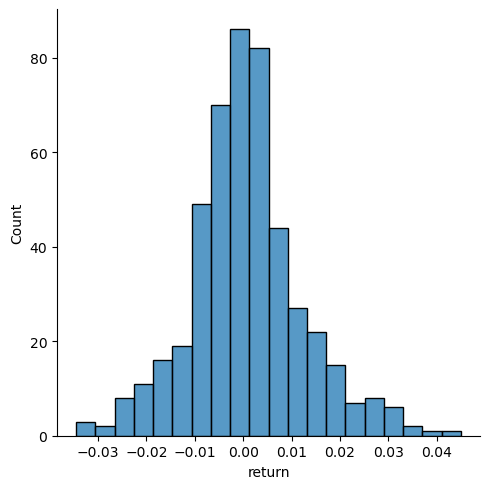

In [78]:
sns.displot(df_totalIndex_return['return'], bins=20)

In [79]:
# We can use the scipy.stats.normaltest() function to check if our data is normally distributed.
from scipy.stats import normaltest

k2, p = normaltest(df_totalIndex_return['return'])
alpha = 0.05
if p < alpha:  # null hypothesis: x comes from a normal distribution.
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis can be rejected


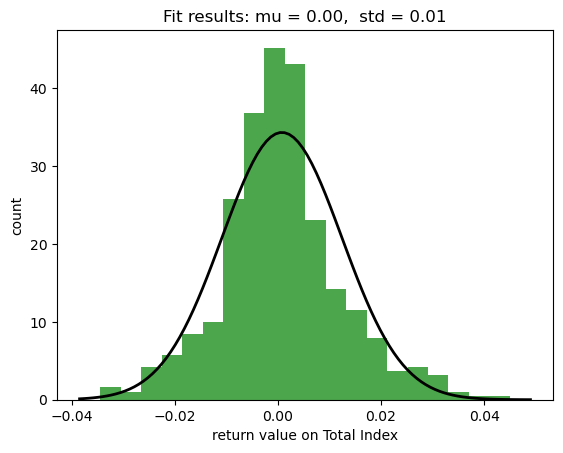

In [80]:
# We can use matplotlib to plot the histogram and For fitting and computing the PDF, we can use scipy.stats.norm, as follows.
# Fit a normal distribution to the data:
mu, std = norm.fit(df_totalIndex_return['return'])

# Plot the histogram.
plt.hist(df_totalIndex_return['return'], bins=20, density=True, alpha=0.7, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('return value on Total Index')
plt.ylabel('count')

plt.show()

Q1_part b


In [81]:
# The Kolmogorov-Smirnov test can be used to test the symmetricness of a data distribution. 
# We test it for symmetricness using normal distribution


from scipy.stats import kstest

statistic, p_value = kstest(df_totalIndex_return['return'], 'norm')

# Print the p-value
print("P-value:", p_value)

# If the p-value is less than the significance level (usually 0.05), 
# we reject the null hypothesis that the data is normally distributed.
# Here it is rejected as the above normaltest said.

P-value: 7.58936886655908e-105


In [82]:
# The Skew test
from scipy.stats import skewtest

stat, p = skewtest(df_totalIndex_return['return'])

print("p-value:", p)

# The null hypothesis for these tests is that the data is normally distributed or has no skewness.
# If the p-value is less than the significance level (usually 0.05), 
# we reject the null hypothesis and conclude that the data is not normally distributed or is skewed.

p-value: 0.0028415575504198804


Q1_part c

In [83]:
def get_mean_var(values, win_size=0, stride=1):
    if win_size==0:
        mean = np.mean(values)
        variance = np.var(values)
    else:
        mean=[]
        variance=[]
        for i in range(len(values)-win_size):
            mean.append(np.mean(values[i: i+win_size]))
            variance.append(np.var(values[i: i+win_size]))
        # mean = np.var(np.array(period_means))
        # variance = np.var(np.array(period_vars))
    return mean, variance


In [91]:
def multiple_displot(data_list, labels):
    fig, axs = plt.subplots(len(data_list), figsize=(8, 10))
    for i, data in enumerate(data_list):
        sns.histplot(data, ax=axs[i], label=labels[i], bins=20)
    plt.show()

In [84]:
# calculate mean and variance for a 2 years old period.
clay_mean, clay_var = get_mean_var(values=df_clay_return['return'].to_numpy())
khodro_mean, khodro_var = get_mean_var(values=df_khodro_return['return'].to_numpy())
mobarake_mean, mobarake_var = get_mean_var(values=df_mobarake_return['return'].to_numpy())
social_mean, social_var = get_mean_var(values=df_social_return['return'].to_numpy())
atlas_mean, atlas_var = get_mean_var(values=df_atlas_return['return'].to_numpy())


In [85]:
print('clay_mean= %f clay_var= %f' % (clay_mean, clay_var))
print('khodro_mean= %f khodro_var= %f' % (khodro_mean, khodro_var))
print('mobarake_mean= %f mobarake_var= %f' % (mobarake_mean, mobarake_var))
print('social_mean= %f social_var= %f' % (social_mean, social_var))
print('atlas_mean= %f atlas_var= %f' % (atlas_mean, atlas_var))

clay_mean= -0.001909 clay_var= 0.000984
khodro_mean= 0.000912 khodro_var= 0.000714
mobarake_mean= -0.000434 mobarake_var= 0.001212
social_mean= -0.002861 social_var= 0.002948
atlas_mean= 0.001043 atlas_var= 0.000222


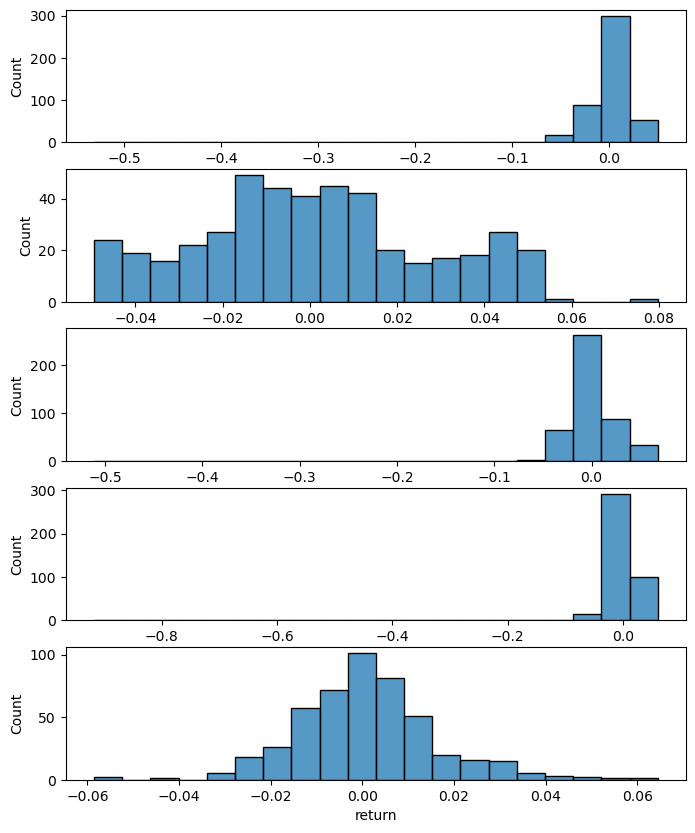

In [92]:
# Now I plot histogram on return values for the 2 years period.
multiple_displot(data_list=[df_clay_return['return'], df_khodro_return['return'], df_mobarake_return['return']
, df_social_return['return'], df_atlas_return['return']],
 labels = ['clay', 'khodro', 'mobarake', 'social', 'atlas'])

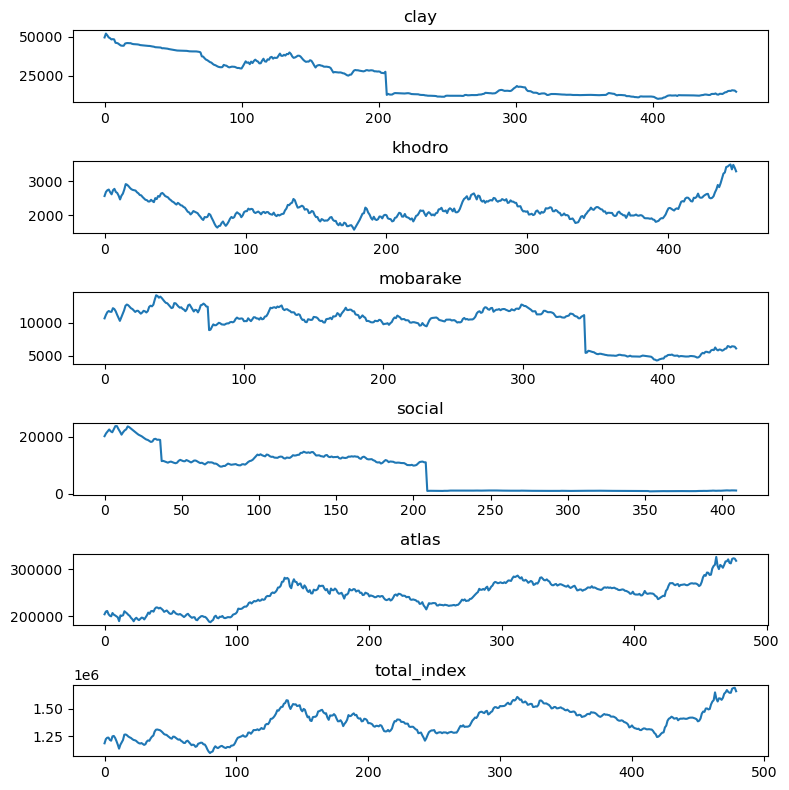

In [93]:
# And also plot the progress in each stock on close price.
data_list=[df_clay.CLOSE, df_khodro.CLOSE, df_mobarake.CLOSE, df_social.CLOSE, df_atlas.CLOSE, index_vals]
labels = ['clay', 'khodro', 'mobarake', 'social', 'atlas', 'total_index']
fig, axs = plt.subplots(len(data_list), figsize=(8, 8))
for i, data in enumerate(data_list):
    axs[i].plot(range(len(data)), data)
    axs[i].set_title(labels[i])
plt.tight_layout()
plt.show()

Q1_ part d

In [94]:
# calculate mean and variance in windows of 20 days period.
clay_mean_ary, clay_var_ary = get_mean_var(values=df_clay_return['return'], win_size=20, stride=1)
khodro_mean_ary, khodro_var_ary = get_mean_var(values=df_khodro_return['return'], win_size=20, stride=1)
mobarake_mean_ary, mobarake_var_ary = get_mean_var(values=df_mobarake_return['return'], win_size=20, stride=1)
social_mean_ary, social_var_ary = get_mean_var(values=df_social_return['return'], win_size=20, stride=1)
atlas_mean_ary, atlas_var_ary = get_mean_var(values=df_atlas_return['return'], win_size=20, stride=1)
index_mean_ary, index_var_ary = get_mean_var(values=df_totalIndex_return['return'], win_size=20, stride=1)

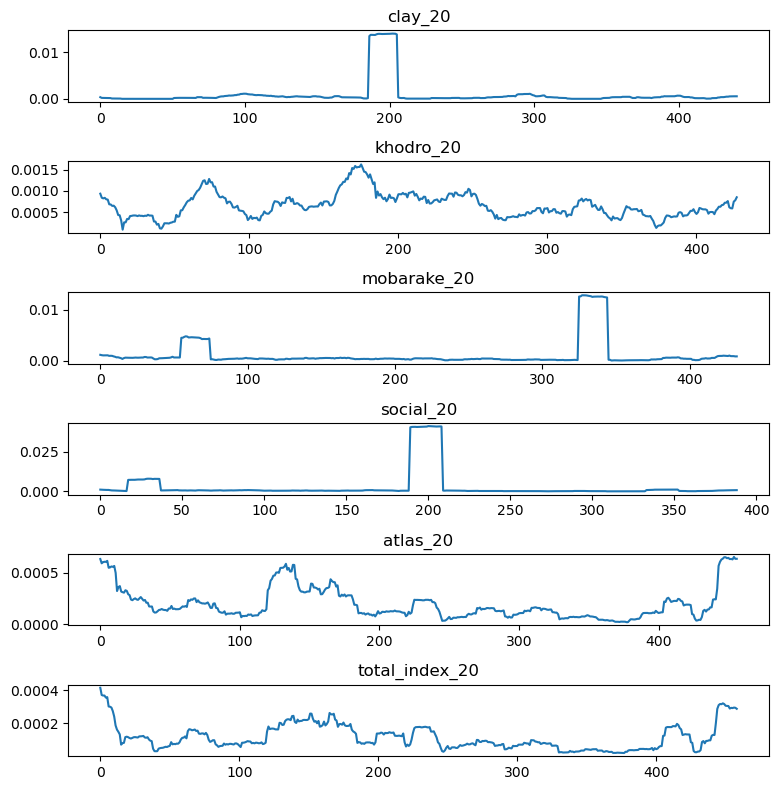

In [95]:
# Now plot the progress in each stock on price variance of defined window sizes.
data_list=[clay_var_ary, khodro_var_ary, mobarake_var_ary, social_var_ary, atlas_var_ary, index_var_ary]
labels = ['clay_20', 'khodro_20', 'mobarake_20', 'social_20', 'atlas_20', 'total_index_20']
fig, axs = plt.subplots(len(data_list), figsize=(8, 8))
for i, data in enumerate(data_list):
    axs[i].plot(range(len(data)), data)
    axs[i].set_title(labels[i])
plt.tight_layout()
plt.show()

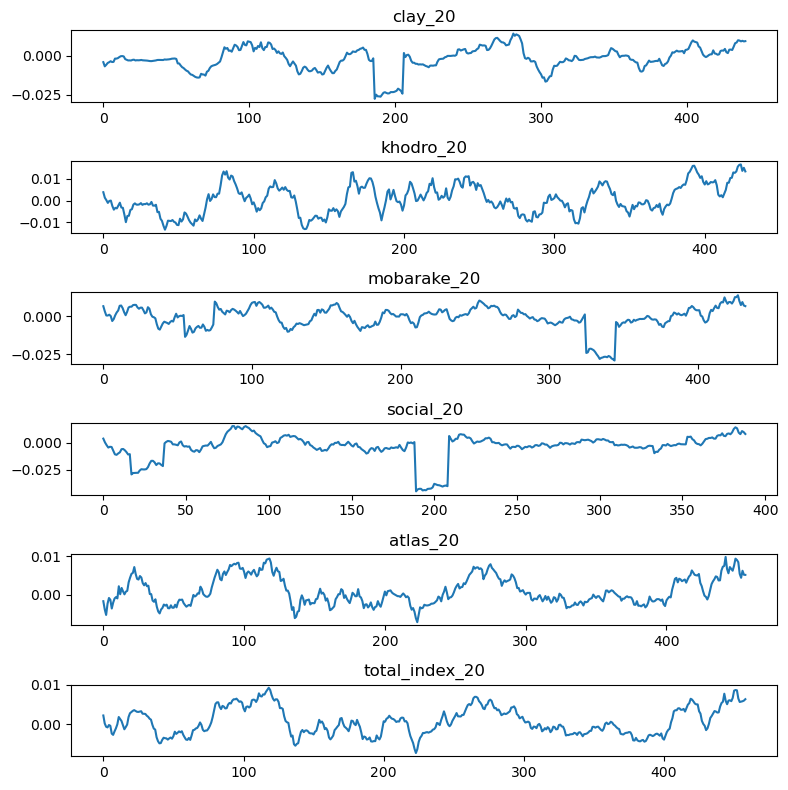

In [96]:
# Now plot the progress in each stock on mean price of defined window sizes.
data_list=[clay_mean_ary, khodro_mean_ary, mobarake_mean_ary, social_mean_ary, atlas_mean_ary, index_mean_ary]
labels = ['clay_20', 'khodro_20', 'mobarake_20', 'social_20', 'atlas_20', 'total_index_20']
fig, axs = plt.subplots(len(data_list), figsize=(8, 8))
for i, data in enumerate(data_list):
    axs[i].plot(range(len(data)), data)
    axs[i].set_title(labels[i])
plt.tight_layout()
plt.show()

Q2_part a

In [97]:
# Delay (lag) range that we are interesting in.
lags = range(6)
import statsmodels.api as sm

acorr = sm.tsa.acf(df_totalIndex_return['return'], nlags = len(lags)-1)
acorr[1:]

array([ 0.30153472, -0.00441886,  0.09146403,  0.01421556, -0.03447565])

Q2_ part b

In [122]:
# Get the common dates
common_dates = pd.Index(df_totalIndex_return.return_date.to_numpy()).intersection(pd.Index(df_clay_return.return_date.to_numpy()))\
    .intersection(pd.Index(df_khodro_return.return_date.to_numpy())).intersection(pd.Index(df_mobarake_return.return_date.to_numpy()))\
    .intersection(pd.Index(df_social_return.return_date.to_numpy())).intersection(pd.Index(df_atlas_return.return_date.to_numpy()))

df_totalIndex_common = df_totalIndex_return[df_totalIndex_return.return_date.isin(common_dates)]
df_clay_common = df_clay_return[df_clay_return.return_date.isin(common_dates)]
df_khodro_common = df_khodro_return[df_khodro_return.return_date.isin(common_dates)]
df_mobarake_common = df_mobarake_return[df_mobarake_return.return_date.isin(common_dates)]
df_social_common = df_social_return[df_social_return.return_date.isin(common_dates)]
df_atlas_common = df_atlas_return[df_atlas_return.return_date.isin(common_dates)]

# print(len(df_totalIndex_common))
# print(len(df_clay_common))
# print(len(df_khodro_common))
# print(len(df_mobarake_common))
# print(len(df_social_common))

In [123]:
# check intersection is applied corretly.
df_totalIndex_common.head(-20)

,return_date,return
0,2021-01-23,0.032173
1,2021-01-24,0.010218
2,2021-01-25,0.000993
3,2021-01-26,-0.016791
4,2021-01-27,-0.006037
...,...,...
451,2022-12-12,0.014390
452,2022-12-13,0.032010
453,2022-12-14,0.012577
454,2022-12-17,-0.001920


<BarContainer object of 5 artists>

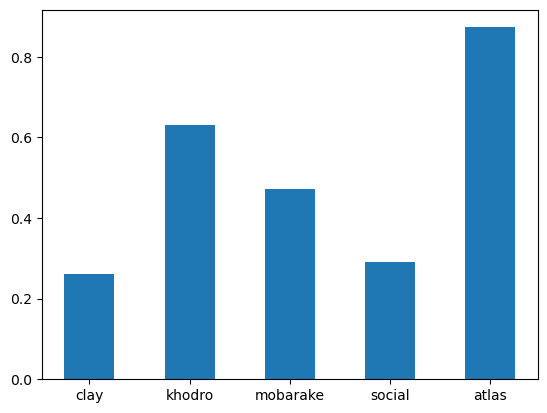

In [132]:
# Now compute cross correlation...
coefs = []
coef, p = pearsonr(df_totalIndex_common['return'], df_clay_common['return'])
coefs.append(coef)
coef, p = pearsonr(df_totalIndex_common['return'], df_khodro_common['return'])
coefs.append(coef)
coef, p = pearsonr(df_totalIndex_common['return'], df_mobarake_common['return'])
coefs.append(coef)
coef, p = pearsonr(df_totalIndex_common['return'], df_social_common['return'])
coefs.append(coef)
coef, p = pearsonr(df_totalIndex_common['return'], df_atlas_common['return'])
coefs.append(coef)

names = ['clay', 'khodro', 'mobarake', 'social', 'atlas']
plt.bar(names, coefs, width=0.5)

Q2_part c

In [344]:
# import datetime
# datetime.datetime.strptime("2/13/2021", '%m/%d/%Y').strftime('%Y-%m-%d')
# first convert '%m/%d/%Y' format to '%Y-%m-%d'  formats that we have for dollar csv file.

df_dollar = file_reader(fpath='Data/dollar_rl.csv', colnames=['DTYYYYMMDD', 'CLOSE'], date_convert_col=None).iloc[::-1]
df_gold = file_reader(fpath='Data/geram18.csv', colnames=['DTYYYYMMDD', 'CLOSE'], date_convert_col=None).iloc[::-1]
df_gold.shape


(586, 2)

In [345]:
df_dollar.drop_duplicates('DTYYYYMMDD', inplace=True)
df_gold.drop_duplicates('DTYYYYMMDD', inplace=True)
df_gold.shape

(579, 2)

In [346]:
df_gold.head()

,DTYYYYMMDD,CLOSE
0,2021-02-02,10955000.0
1,2021-02-03,10883000.0
2,2021-02-04,10744000.0
3,2021-02-06,10901000.0
4,2021-02-07,10876000.0


In [350]:
df_dollar = df_dollar[(df_dollar['DTYYYYMMDD'] >= start_date) & (df_dollar['DTYYYYMMDD'] <= end_date)]
df_gold = df_gold[(df_gold['DTYYYYMMDD'] >= start_date) & (df_gold['DTYYYYMMDD'] <= end_date)]

print(df_gold.shape)
# Access two consecutive elements of a list and calcualte return value for these two elements.
df_dollar_return = pd.DataFrame({
    'return_date': list(df_dollar.DTYYYYMMDD.iloc[1:]),
    'return': list(map(lambda zip_val: (zip_val[1] - zip_val[0]) / zip_val[0], zip(df_dollar.CLOSE, df_dollar.CLOSE.iloc[1:])))
})

df_gold_return = pd.DataFrame({
    'return_date': list(df_gold.DTYYYYMMDD.iloc[1:]),
    'return': list(map(lambda zip_val: (zip_val[1] - zip_val[0]) / zip_val[0], zip(df_gold.CLOSE, df_gold.CLOSE.iloc[1:])))
})
df_gold_return.head()

(569, 2)


,return_date,return
0,2021-02-03,-0.006572
1,2021-02-04,-0.012772
2,2021-02-06,0.014613
3,2021-02-07,-0.002293
4,2021-02-08,0.039904


In [351]:
# Get the common dates
with_gold_common_dates = pd.Index(df_totalIndex_return.return_date.to_numpy()).intersection(pd.Index(df_clay_return.return_date.to_numpy()))\
    .intersection(pd.Index(df_khodro_return.return_date.to_numpy())).intersection(pd.Index(df_mobarake_return.return_date.to_numpy()))\
    .intersection(pd.Index(df_social_return.return_date.to_numpy())).intersection(pd.Index(df_atlas_return.return_date.to_numpy()))\
        .intersection(pd.Index(df_gold_return.return_date.to_numpy())).intersection(pd.Index(df_dollar_return.return_date.to_numpy()))

df_totalIndex_common_with_gold = df_totalIndex_return[df_totalIndex_return.return_date.isin(with_gold_common_dates)]
df_clay_common_with_gold = df_clay_return[df_clay_return.return_date.isin(with_gold_common_dates)]
df_khodro_common_with_gold = df_khodro_return[df_khodro_return.return_date.isin(with_gold_common_dates)]
df_mobarake_common_with_gold = df_mobarake_return[df_mobarake_return.return_date.isin(with_gold_common_dates)]
df_social_common_with_gold = df_social_return[df_social_return.return_date.isin(with_gold_common_dates)]
df_atlas_common_with_gold = df_atlas_return[df_atlas_return.return_date.isin(with_gold_common_dates)]
df_gold_common_with_gold = df_gold_return[df_gold_return.return_date.isin(with_gold_common_dates)]
df_dollar_common_with_gold = df_dollar_return[df_dollar_return.return_date.isin(with_gold_common_dates)]

len(with_gold_common_dates)
len(df_gold_common_with_gold)

271

In [353]:
df_dollar_common_with_gold.head()

,return_date,return
0,2021-02-03,-0.004399
2,2021-02-06,0.000337
3,2021-02-07,-0.002484
4,2021-02-08,-0.000084
5,2021-02-09,0.017262


0.2896561241754059
0.10656927364452742


<BarContainer object of 7 artists>

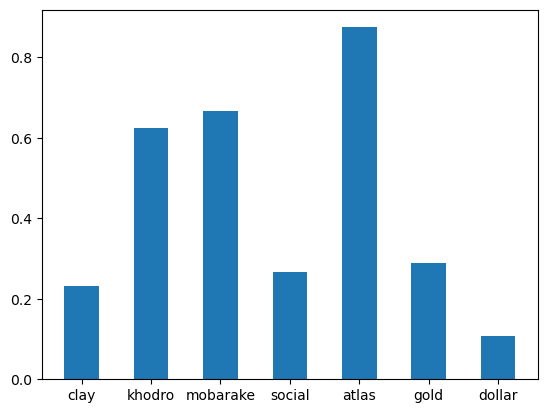

In [354]:
# Now compute cross correlation...
coefs = []
coef, p = pearsonr(df_totalIndex_common_with_gold['return'], df_clay_common_with_gold['return'])
coefs.append(coef)
coef, p = pearsonr(df_totalIndex_common_with_gold['return'], df_khodro_common_with_gold['return'])
coefs.append(coef)
coef, p = pearsonr(df_totalIndex_common_with_gold['return'], df_mobarake_common_with_gold['return'])
coefs.append(coef)
coef, p = pearsonr(df_totalIndex_common_with_gold['return'], df_social_common_with_gold['return'])
coefs.append(coef)
coef, p = pearsonr(df_totalIndex_common_with_gold['return'], df_atlas_common_with_gold['return'])
coefs.append(coef)
coef, p = pearsonr(df_totalIndex_common_with_gold['return'], df_gold_common_with_gold['return'])
coefs.append(coef)
print(coef)
coef, p = pearsonr(df_totalIndex_common_with_gold['return'], df_dollar_common_with_gold['return'])
coefs.append(coef)
print(coef)

names = ['clay', 'khodro', 'mobarake', 'social', 'atlas', 'gold', 'dollar']
plt.bar(names, coefs, width=0.5)

Q3_ part a

In [133]:
from sklearn.linear_model import LinearRegression

In [134]:
# create a dataframe with multiple lags of the time series
# According to the results of Autocorrelation, I test data for one day before and for 3 days before.
lags = 1
df = pd.DataFrame({'y': df_totalIndex_return['return']})
for i in range(1, lags+1):
    df[f'lag_{i}'] = df['y'].shift(i)
df.dropna(inplace=True)

# separate the target variable (next step prediction) and features (lagged values)
X = df.drop('y', axis=1)
y = df['y']


# split the data into training and testing sets
train_size = int(0.7 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# fit the linear regression model to the training data
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)

# evaluate the model performance
error = np.mean((y_test - y_pred) ** 2)
print("Mean Squared Error: ", error)


Mean Squared Error:  0.0001073374520400513


Q3_ part b

In [179]:
def winsized_data(data, winsize, nextsteps):
    x = [data[i:i+winsize] for i in range(len(data)-winsize-nextsteps)]
    y = [data[i+winsize-1+nextsteps] for i in range(len(data)-winsize-nextsteps)]
    return x, y

In [187]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

next_steps=4
data = df_totalIndex_return['return']
# preprocessed_data = []
for i in range(1, next_steps+1):
    x, y = winsized_data(data=data, winsize=1, nextsteps=i)
    label=[]
    for item in y:
        if item>=0:
            label.append(1)
        else:
            label.append(0)
    y = np.array(label)
    x = np.array(x)
    # preprocessed_data.append((x, y))
    # split the data into training and testing sets
    train_size = int(0.7 * len(y))
    X_train, X_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Scale the input variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    x_test_scaled = scaler.transform(X_test)
    
    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)

    # Predict target variable for new data
    y_test_pred = model.predict(x_test_scaled)

    confusion_matrix = pd.crosstab(y_test, y_test_pred, rownames=['Actual'], colnames=['Predicted'])
    print('result for {} next steps: '.format(i))
    print(confusion_matrix)
    print('*****************************************************************************')


result for 1 next steps: 
Predicted   0   1
Actual           
0          45  30
1          22  47
*****************************************************************************
result for 2 next steps: 
Predicted  0   1
Actual          
0          3  72
1          5  63
*****************************************************************************
result for 3 next steps: 
Predicted   0   1
Actual           
0          13  62
1          18  50
*****************************************************************************
result for 4 next steps: 
Predicted  0   1
Actual          
0          4  71
1          7  61
*****************************************************************************


Q3_ part c

In [256]:
type(df_totalIndex_common['return'])

pandas.core.series.Series

In [271]:
lags = 10

# Get daily return for  Total Indexes
x_totalIndex, y = winsized_data(df_totalIndex_common['return'].tolist(), winsize=lags, nextsteps=1)
x_totalIndex = np.array(x_totalIndex)
y = np.array(y)

x_clay, _ = winsized_data(df_clay_common['return'].tolist(), winsize=lags, nextsteps=1)
x_clay = np.array(x_clay)

x_khodro, _ = winsized_data(df_khodro_common['return'].tolist(), winsize=lags, nextsteps=1)
x_khodro = np.array(x_khodro)

x_mobarakeh, _ = winsized_data(df_mobarake_common['return'].tolist(), winsize=lags, nextsteps=1)
x_mobarakeh = np.array(x_mobarakeh)

x_social, _ = winsized_data(df_social_common['return'].tolist(), winsize=lags, nextsteps=1)
x_social = np.array(x_social)

x_atlas, _ = winsized_data(df_atlas_common['return'].tolist(), winsize=lags, nextsteps=1)
x_atlas = np.array(x_atlas)

# put the above feature np arrays into one in column-wise
x = np.hstack((x_totalIndex, x_clay, x_khodro, x_mobarakeh, x_social, x_atlas))

print(x.shape)
print(y.shape)

(329, 60)
(329,)


In [272]:
# Now train the model

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=False)

# Standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

# fit the linear regression model to the training data
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# make predictions on the testing data
y_pred = model.predict(x_test_scaled)

# evaluate the model performance
error = np.mean((y_test - y_pred) ** 2)
print("Mean Squared Error On Test: ", error)



Mean Squared Error On Test:  0.0001435673263634935


In [273]:
# Also check the classification accuracy
from sklearn.metrics import confusion_matrix
true_label=[]
for item in y_test:
    if item>=0:
        true_label.append(1)
    else:
        true_label.append(0)
true_label = np.array(true_label)

pred_label=[]
for item in y_pred:
    if item>=0:
        pred_label.append(1)
    else:
        pred_label.append(0)
pred_label = np.array(pred_label)

conf_matrix = confusion_matrix(true_label, pred_label)

print(conf_matrix)


[[26 24]
 [19 30]]


Q3_ part d

In [248]:
from sklearn.linear_model import Lasso

# prepare data
lags = 10
x, y = winsized_data(data, winsize=lags, nextsteps=1)
X_train, X_test, y_train, y_test = train_test_split(np.array(x), np.array(y), test_size=0.3, random_state=42)

 # Scale the input variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

model = Lasso(alpha=.001)
model.fit(X_train_scaled, y_train)

# Evaluate model on test data
y_test_pred = model.predict(x_test_scaled)
test_score = model.score(x_test_scaled, y_test)
train_score = model.score(X_train_scaled, y_train)
print("Test score:", test_score)
print("Train score:", train_score)

error = np.mean((y_test - y_test_pred) ** 2)
print("Mean Squared Error On Test : ", error)

y_train_predict = model.predict(X_train_scaled)
error = np.mean((y_train - y_train_predict) ** 2)
print("Mean Squared Error On Train : ", error)

model.coef_ 

Test score: 0.013577399396172418
Train score: 0.12806630324382706
Mean Squared Error On Test :  0.00011240646475867021
Mean Squared Error On Train :  0.00011732165167691157


array([ 0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.00109083, -0.        ,  0.00282932])